In [1]:
if "logger" in globals() and  len(logger.handlers) >= 1:
    # To suppress debug output from the logger defined in .ipython/profile_default/ipython_config.py
    logger.handlers.pop()

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.output_html { display: block; margin-left: auto; margin-right: auto; }</style>"))

In [3]:
import sys
import numpy
import logging
import numpy as np
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import colorcet
import matplotlib
from matplotlib import pyplot
from matplotlib import pyplot as plt
pyplot.style.use("tlrh")

sys.path.insert(0, "/supaharris-client")
from supaharrisclient.units import arcmin2parsec
from supaharrisclient.units import parsec2arcmin
from supaharrisclient.utils import suppress_stdout
from supaharrisclient.utils import print_progressbar
from supaharrisclient.client import SupaHarrisClient

sys.path.insert(0, "/supaharris")
from utils import convert_gc_names_from_sh_to_any

sys.path.insert(0, "/limepy")
import limepy

logging.basicConfig(stream=sys.stdout, format="%(message)s")
logger = logging.getLogger(); logger.level = logging.INFO
for h in logger.handlers: h.setLevel(logger.level)

# Setup the observational data we'd like to use

In [4]:
## Parsers from Auriga project
# Harris (1996, 2010 ed.) --> various observations for 157 MW GCs
sys.path.insert(0, "/auriga/src")
from mw_m31_gc_observations import read_MWandM31_data
MW_h96e10, MW_v13, M31_c11, M31_cr16 = read_MWandM31_data()
logger.info("Harris (1996, 2010 ed.)")
logger.info("  Found {0} GCs".format(len(MW_h96e10)))
logger.info("  Available fields:\n    {0}".format(MW_h96e10.dtype))
logger.info("  Available clusters:\n    {0}".format(MW_h96e10["ID"].astype("U10")))

Loading KWallet
Loading SecretService
Loading Windows
Loading chainer
Loading macOS
Harris (1996, 2010 ed.)
  Found 157 GCs
  Available fields:
    [('ID', 'S10'), ('Name', 'S10'), ('RADEC', 'O'), ('LONLAT', 'O'), ('R_Sun', '<f8'), ('R_gc', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Rproj', '<f8'), ('f10', 'V10'), ('FeH', '<f8'), ('wt', '<i8'), ('EBminV', '<f8'), ('V_HB', '<f8'), ('mminMV', '<f8'), ('V_t', '<f8'), ('M_Vt', '<f8'), ('UminB', '<f8'), ('BminV', '<f8'), ('VminR', '<f8'), ('VminI', '<f8'), ('spt', 'S2'), ('ellip', '<f8'), ('f24', 'V10'), ('v_r', '<f8'), ('v_r_err', '<f8'), ('v_LSR', '<f8'), ('sig_v', '<f8'), ('sig_v_err', '<f8'), ('c', '<f8'), ('collapsed', 'S2'), ('r_c', '<f8'), ('r_h', '<f8'), ('mu_V', '<f8'), ('rho_0', '<f8'), ('lgtc', '<f8'), ('lgth', '<f8'), ('Mass', '<f8')]
  Available clusters:
    ['NGC 104' 'NGC 288' 'NGC 362' 'Whiting 1' 'NGC 1261' 'Pal 1' 'AM 1'
 'Eridanus' 'Pal 2' 'NGC 1851' 'NGC 1904' 'NGC 2298' 'NGC 2419' 'Ko 2'
 'Pyxis' 'NGC 2808' 'E

In [5]:
# Vandenberg (2013) --> Ages
dtype = numpy.dtype(MW_v13.dtype.descr + [("ID", "U10")])
bla = numpy.empty(MW_v13.shape, dtype=dtype)
bla[list(MW_v13.dtype.names)] = MW_v13
bla["ID"] = [convert_gc_names_from_sh_to_any(n, reverse=True) for n in ["NGC {0}".format(gc["NGC"])
    if gc["NGC"] != -1 else gc["Name"].astype("U10") for gc in MW_v13]]
MW_v13 = bla
logger.info("\nVandenberg (2013)")
logger.info("  Found {0} GCs".format(len(MW_v13)))
logger.info("  Available fields:\n    {0}".format(MW_v13.dtype))
logger.info("  Available clusters:\n    {0}".format(MW_v13["ID"]))


Vandenberg (2013)
  Found 55 GCs
  Available fields:
    [('NGC', '<i8'), ('Name', 'S10'), ('FeH', '<f8'), ('Age', '<f8'), ('fAge', '<f8'), ('Method', 'S1'), ('Fig', 'S5'), ('Range', 'S12'), ('HBType', '<f8'), ('R_GC', '<f8'), ('M_V', '<f8'), ('v_e0', '<f8'), ('log10sigma0', '<f8'), ('Rproj', '<f8'), ('ID', '<U10')]
  Available clusters:
    ['NGC 104' 'NGC 288' 'NGC 362' 'NGC 1261' 'NGC 1851' 'NGC 2808' 'NGC 3201'
 'NGC 4147' 'NGC 4590' 'NGC 4833' 'NGC 5024' 'NGC 5053' 'NGC 5272'
 'NGC 5286' 'NGC 5466' 'NGC 5904' 'NGC 5927' 'NGC 5986' 'NGC 6101'
 'NGC 6121' 'NGC 6144' 'NGC 6171' 'NGC 6205' 'NGC 6218' 'NGC 6254'
 'NGC 6304' 'NGC 6341' 'NGC 6352' 'NGC 6362' 'NGC 6366' 'NGC 6397'
 'NGC 6496' 'NGC 6535' 'NGC 6541' 'NGC 6584' 'NGC 6624' 'NGC 6637'
 'NGC 6652' 'NGC 6656' 'NGC 6681' 'NGC 6715' 'NGC 6717' 'NGC 6723'
 'NGC 6752' 'NGC 6779' 'NGC 6809' 'NGC 6838' 'NGC 6934' 'NGC 6981'
 'NGC 7078' 'NGC 7089' 'NGC 7099' 'Arp 2' 'Pal 12' 'Terzan 8']


In [6]:
## Parsers from Supaharris project
# Harris (1996, 2010 ed.)
from data.parse_harris_1996ed2010 import parse_harris1996ed2010
h96_gc = parse_harris1996ed2010(logger)
logger.info("\nHarris (1996, 2010ed.) SupaHarris parser")
logger.info("  Found {0} GCs".format(len(h96_gc)))
logger.info("  Available fields:\n    {0}".format([k for k in vars(h96_gc["NGC 104"]).keys()]))
logger.info("  Available clusters:\n    {0}".format([gc for gc in h96_gc.keys()]))


Harris (1996, 2010ed.) SupaHarris parser
  Found 157 GCs
  Available fields:
    ['logger', 'gid', 'name', 'ra', 'dec', 'longitude', 'latitude', 'dist_from_sun', 'dist_from_gal_cen', 'X', 'Y', 'Z', 'metallicity', 'w_mean_met', 'eb_v', 'v_hb', 'app_vd_mod', 'v_t', 'm_v_t', 'ph_u_b', 'ph_b_v', 'ph_v_r', 'ph_v_i', 'spt', 'ellipticity', 'v_r', 'v_r_err', 'c_LSR', 'sig_v', 'sig_v_err', 'sp_c', 'sp_r_c', 'sp_r_h', 'sp_mu_V', 'sp_rho_0', 'sp_lg_tc', 'sp_lg_th', 'sig_err', 'rho_0', 'lg_tc', 'lg_th']
  Available clusters:
    ['NGC 104', 'NGC 288', 'NGC 362', 'Whiting 1', 'NGC 1261', 'Pal 1', 'AM 1', 'Eridanus', 'Pal 2', 'NGC 1851', 'NGC 1904', 'NGC 2298', 'NGC 2419', 'Ko 2', 'Pyxis', 'NGC 2808', 'E 3', 'Pal 3', 'NGC 3201', 'Pal 4', 'Ko 1', 'NGC 4147', 'NGC 4372', 'Rup 106', 'NGC 4590', 'NGC 4833', 'NGC 5024', 'NGC 5053', 'NGC 5139', 'NGC 5272', 'NGC 5286', 'AM 4', 'NGC 5466', 'NGC 5634', 'NGC 5694', 'IC 4499', 'NGC 5824', 'Pal 5', 'NGC 5897', 'NGC 5904', 'NGC 5927', 'NGC 5946', 'BH 176', 'NGC

In [7]:
# Balbinot & Gieles (2018) --> Jacobi radius
from data.parse_balbinot_2018 import parse_balbinot_2018
b18 = parse_balbinot_2018(logger)
logger.info("\nBalbinot & Gieles (2018)")
logger.info("  Found {0} GCs".format(len(b18)))
logger.info("  Available fields:\n    {0}".format(b18.dtype))
logger.info("  Available clusters:\n    {0}".format(b18["Name"]))


Balbinot & Gieles (2018)
  Found 145 GCs
  Available fields:
    [('Name', '<U16'), ('mu_alpha', '<f8'), ('mu_alpha_err', '<f8'), ('mu_delta', '<f8'), ('mu_delta_err', '<f8'), ('V_rm los', '<f8'), ('V_rm los_err', '<f8'), ('R_apo', '<f8'), ('R_apo_err', '<f8'), ('R_peri', '<f8'), ('R_peri_err', '<f8'), ('ecc', '<f8'), ('ecc_err', '<f8'), ('M_i', '<f8'), ('M_i_err', '<f8'), ('mu', '<f8'), ('mu_err', '<f8'), ('phi', '<f8'), ('phi_err', '<f8'), ('r_J', '<f8'), ('r_J_err', '<f8'), ('Refs', '<U16')]
  Available clusters:
    ['NGC 104' 'NGC 288' 'NGC 362' 'Whiting 1' 'NGC 1261' 'Pal 1' 'AM 1'
 'Eridanus' 'Pal 2' 'NGC 1851' 'NGC 1904' 'NGC 2298' 'NGC 2419' 'Pyxis'
 'NGC 2808' 'E 3' 'Pal 3' 'NGC 3201' 'Pal 4' 'NGC 4147' 'NGC 4372'
 'Rup 106' 'NGC 4590' 'NGC 4833' 'NGC 5024' 'NGC 5053' 'NGC 5139'
 'NGC 5272' 'NGC 5286' 'AM 4' 'NGC 5466' 'NGC 5634' 'NGC 5694' 'IC 4499'
 'NGC 5824' 'Pal 5' 'NGC 5897' 'NGC 5904' 'NGC 5927' 'NGC 5946' 'NGC 5986'
 'Pal 14' 'Lynga 7' 'NGC 6093' 'NGC 6121' 'NGC 6101

In [8]:
# Trager+ (1995) --> Surface Brightness for 125 MW GCs
from data.parse_trager_1995 import parse_trager_1995_gc
from data.parse_trager_1995 import parse_trager_1995_tables
t95_gc = parse_trager_1995_gc(logger)
t95_tables = parse_trager_1995_tables(logger)
logger.info("\nTrager+ 1995")
logger.info("  Found {0} GCs".format(len(t95_gc)))
logger.info("  Available fields:\n    {0}".format(t95_gc.dtype))
logger.info("  Available clusters:\n    {0}".format(t95_gc["Name"]))


Trager+ 1995
  Found 125 GCs
  Available fields:
    [('Name', '<U8'), ('Nsb', '<i2'), ('SName', '<U19'), ('Prof', '<U4'), ('Simbad', '<U6'), ('_RA', '<f8'), ('_DE', '<f8')]
  Available clusters:
    ['AM 1' 'Arp 2' 'HP 1' 'IC 1276' 'IC 4499' 'NGC 104' 'NGC 1261' 'NGC 1851'
 'NGC 1904' 'NGC 2298' 'NGC 2419' 'NGC 2808' 'NGC 288' 'NGC 3201'
 'NGC 362' 'NGC 4147' 'NGC 4372' 'NGC 4590' 'NGC 5024' 'NGC 5053'
 'NGC 5139' 'NGC 5272' 'NGC 5286' 'NGC 5466' 'NGC 5634' 'NGC 5694'
 'NGC 5824' 'NGC 5897' 'NGC 5904' 'NGC 5927' 'NGC 5946' 'NGC 5986'
 'NGC 6093' 'NGC 6101' 'NGC 6121' 'NGC 6139' 'NGC 6144' 'NGC 6171'
 'NGC 6205' 'NGC 6218' 'NGC 6229' 'NGC 6235' 'NGC 6254' 'NGC 6256'
 'NGC 6266' 'NGC 6273' 'NGC 6284' 'NGC 6287' 'NGC 6293' 'NGC 6304'
 'NGC 6316' 'NGC 6325' 'NGC 6333' 'NGC 6341' 'NGC 6342' 'NGC 6352'
 'NGC 6355' 'NGC 6356' 'NGC 6362' 'NGC 6366' 'NGC 6380' 'NGC 6388'
 'NGC 6397' 'NGC 6401' 'NGC 6402' 'NGC 6426' 'NGC 6440' 'NGC 6441'
 'NGC 6453' 'NGC 6496' 'NGC 6517' 'NGC 6522' 'NGC 6528' 

In [9]:
# Miocchi+ 2013 --> HST + Ground-based observations of 26 MW GCs /w King/Wilson fits
from data.parse_miocchi_2013 import parse_miocchi_2013_table2
from data.parse_miocchi_2013 import parse_miocchi_2013_profiles
m13_t2 = parse_miocchi_2013_table2(logger)
m13_profs = parse_miocchi_2013_profiles(logger)

logger.info("\nMiocchi+ 2013")
logger.info("  Found {0} GCs".format(len(m13_t2)))
logger.info("  Available fields:\n    {0}".format(m13_t2.dtype))
logger.info("  Available clusters:\n    {0}".format(m13_t2["NGCno."]))

Already have: /supaharris/data/MW_GCS_Miocchi2013/table2.txt


Miocchi+ 2013
  Found 52 GCs
  Available fields:
    [('NGCno.', '<U16'), ('mod', '<U1'), ('W0', '<f8'), ('+dW0', '<f8'), ('-dW0', '<f8'), ('rc', '<f8'), ('+drc', '<f8'), ('-drc', '<f8'), ('r0', '<f8'), ('+dr0', '<f8'), ('-dr0', '<f8'), ('c0', '<f8'), ('+dc0', '<f8'), ('-dc0', '<f8'), ('rl', '<f8'), ('+drl', '<f8'), ('-drl', '<f8'), ('rhm', '<f8'), ('+drhm', '<f8'), ('-drhm', '<f8'), ('re', '<f8'), ('+dre', '<f8'), ('-dre', '<f8'), ('N_BG', '<f8'), ('chi2_nu', '<f8')]
  Available clusters:
    ['NGC 104' 'NGC 104' 'NGC 288' 'NGC 288' 'NGC 1851' 'NGC 1851' 'NGC 1904'
 'NGC 1904' 'NGC 2419' 'NGC 2419' 'NGC 5024' 'NGC 5024' 'NGC 5272'
 'NGC 5272' 'NGC 5466' 'NGC 5466' 'NGC 5824' 'NGC 5824' 'NGC 5904'
 'NGC 5904' 'NGC 6121' 'NGC 6121' 'NGC 6205' 'NGC 6205' 'NGC 6229'
 'NGC 6229' 'NGC 6254' 'NGC 6254' 'NGC 6266' 'NGC 6266' 'NGC 6341'
 'NGC 6341' 'NGC 6626' 'NGC 6626' 'NGC 6809' 'NGC 6809' 'NGC 6864'
 'NGC 6864' 'NGC 7089' 'NGC 7

In [10]:
# Hilker+ 2019 --> Orbital parameters for 154 MW GCs
from data.parse_hilker_2019 import parse_hilker_2019_orbits
from data.parse_hilker_2019 import parse_hilker_2019_combined
from data.parse_hilker_2019 import parse_hilker_2019_radial_velocities
from data.parse_hilker_2019 import parse_baumgardt_2019_mnras_482_5138_table1
from data.parse_hilker_2019 import parse_baumgardt_2019_mnras_482_5138_table4

h19_orbits = parse_hilker_2019_orbits(logger)
h19_combined = parse_hilker_2019_combined(logger)
h19_table1 = parse_baumgardt_2019_mnras_482_5138_table1()
h19_table4 = parse_baumgardt_2019_mnras_482_5138_table4()

logger.info("\nHilker, Baumgardt, Sollima, Bellini 2019")
logger.info("  Orbits table")
logger.info("    Found {0} GCs".format(len(h19_orbits)))
logger.info("    Available fields:\n    {0}".format(h19_orbits.dtype))
logger.info("    Available clusters:\n    {0}".format(h19_orbits["Cluster"]))

logger.info("\n  Combined table")
logger.info("    Found {0} GCs".format(len(h19_combined)))
logger.info("    Available fields:\n    {0}".format(h19_combined.dtype))
logger.info("    Available clusters:\n    {0}".format(h19_combined["Cluster"]))


Hilker, Baumgardt, Sollima, Bellini 2019
  Orbits table
    Found 154 GCs
    Available fields:
    [('Cluster', '<U16'), ('RA', '<f8'), ('DEC', '<f8'), ('l', '<f8'), ('b', '<f8'), ('Rsun', '<f8'), ('ERsun', '<f8'), ('R_GC', '<f8'), ('RV', '<f8'), ('ERV', '<f8'), ('mualpha', '<f8'), ('mualpha_err', '<f8'), ('mu_delta', '<f8'), ('mu_delta_err', '<f8'), ('rhopmrade', '<f8'), ('X', '<f8'), ('DX', '<f8'), ('Y', '<f8'), ('DY', '<f8'), ('Z', '<f8'), ('DZ', '<f8'), ('U', '<f8'), ('DU', '<f8'), ('V', '<f8'), ('DV', '<f8'), ('W', '<f8'), ('DW', '<f8'), ('RPERI', '<f8'), ('RPERI_err', '<f8'), ('RAP', '<f8'), ('RAP_err', '<f8')]
    Available clusters:
    ['NGC 104' 'NGC 288' 'NGC 362' 'Whiting 1' 'NGC 1261' 'Pal 1' 'AM 1'
 'Eridanus' 'Pal 2' 'NGC 1851' 'NGC 1904' 'NGC 2298' 'NGC 2419' 'Pyxis'
 'NGC 2808' 'E 3' 'Pal 3' 'NGC 3201' 'Pal 4' 'Crater' 'NGC 4147'
 'NGC 4372' 'Rup 106' 'NGC 4590' 'NGC 4833' 'NGC 5024' 'NGC 5053'
 'NGC 5139' 'NGC 5272' 'NGC 5286' 'AM 4' 'NGC 5466' 'NGC 5634' 'NGC 5694'

In [11]:
# deBoer+ 2019
from data.parse_deBoer_2019 import parse_deBoer_2019_fits
from data.parse_deBoer_2019 import parse_deBoer_2019_member_stars
from data.parse_deBoer_2019 import parse_deBoer_2019_stitched_profiles

deB19_fits = parse_deBoer_2019_fits(logger)
deB19_stitched = parse_deBoer_2019_stitched_profiles(logger)

logger.info("\ndeBoer+ 2019")
logger.info("  Found {0} GCs".format(len(deB19_fits)))
logger.info("  Available fields:\n    {0}".format(deB19_fits.dtype))
logger.info("  Available clusters:\n    {0}".format(deB19_fits["id"]))


deBoer+ 2019
  Found 81 GCs
  Available fields:
    [('id', '<U12'), ('W_lime', '<f8'), ('e_W_lime', '<f8'), ('g_lime', '<f8'), ('e_g_lime', '<f8'), ('rt_lime', '<f8'), ('e_rt_lime', '<f8'), ('M_lime', '<f8'), ('e_M_lime', '<f8'), ('W_pe', '<f8'), ('e_W_pe', '<f8'), ('eta_pe', '<f8'), ('e_eta_pe', '<f8'), ('log1minB_pe', '<f8'), ('e_log1minB_pe', '<f8'), ('rt_pe', '<f8'), ('e_rt_pe', '<f8'), ('M_pe', '<f8'), ('e_M_pe', '<f8'), ('W_king', '<f8'), ('e_W_king', '<f8'), ('rt_king', '<f8'), ('e_rt_king', '<f8'), ('M_king', '<f8'), ('e_M_king', '<f8'), ('W_wil', '<f8'), ('e_W_wil', '<f8'), ('rt_wil', '<f8'), ('e_rt_wil', '<f8'), ('M_wil', '<f8'), ('e_M_wil', '<f8'), ('log_fpe', '<f8'), ('e_log_fpe', '<f8'), ('chi2_king', '<f8'), ('chi2red_king', '<f8'), ('chi2_wil', '<f8'), ('chi2red_wil', '<f8'), ('chi2_lime', '<f8'), ('chi2red_lime', '<f8'), ('chi2_pe', '<f8'), ('chi2red_pe', '<f8'), ('kingtrunc', '<f8'), ('kinghalf', '<f8'), ('wiltrunc', '<f8'), ('wilhalf', '<f8'), ('limehalf', '<f8'), (

# Inspect the projected radial star count profile of NGC 1261

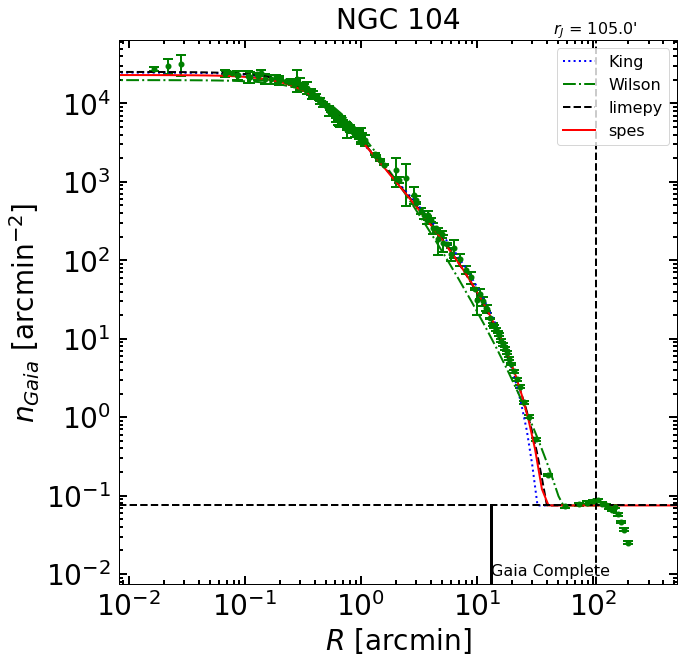

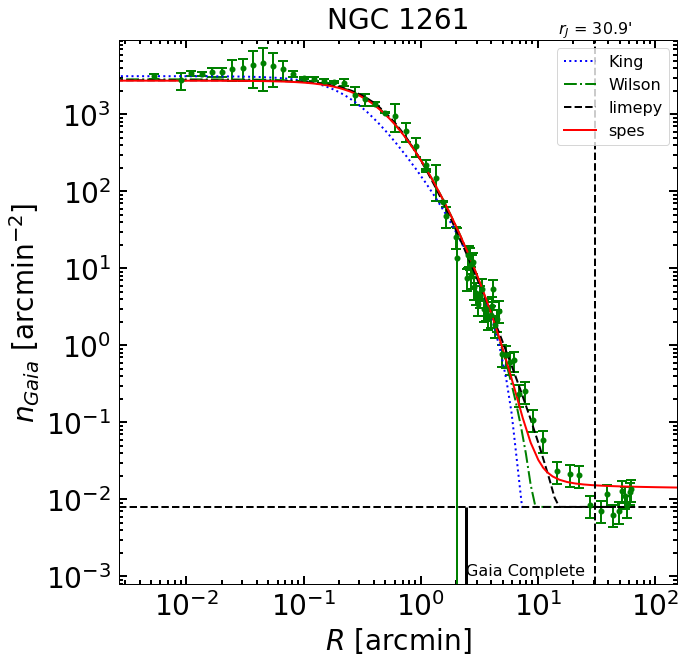

In [12]:
from data.parse_deBoer_2019 import plot_deBoer_2019

matplotlib.rcParams.update({"text.usetex": False})
for i, fit in enumerate(deB19_fits):
    gc_name = fit["id"]
    if gc_name != "NGC 1261" and gc_name != "NGC 104": continue

    distance_kpc = h96_gc[gc_name].dist_from_sun
    imatch, = numpy.where(b18["Name"] == gc_name)[0]
    rJ_pc = b18[imatch]["r_J"]
    rJ = parsec2arcmin(rJ_pc, distance_kpc)

    fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))
    fig = plot_deBoer_2019(logger, fit, deB19_stitched[gc_name], distance_kpc, rJ_pc, rJ, fig=fig, has_tex=False)
    pyplot.show(fig)
    
    # if i > 10: break
matplotlib.rcParams.update({"text.usetex": True})

# Now fit the models to the data instead of taking the best-fit parameters from deBoer+ 2019 and plotting that

In [13]:
# from tlrh_profiles import fit_king
# TODO

# Inspect the MWPotential2014

In [14]:
# Because explicit is better than implicit
from galpy.potential.PowerSphericalPotentialwCutoff import PowerSphericalPotentialwCutoff
from galpy.potential.MiyamotoNagaiPotential import MiyamotoNagaiPotential
from galpy.potential.TwoPowerSphericalPotential import NFWPotential
import galpy.util.bovy_conversion as conversion

# See Table 1 in galpy paper: Bovy (2014)
MWPotential2014= [
    # alpha: inner power; rc: cut-off radius
    PowerSphericalPotentialwCutoff(normalize=0.05, alpha=1.8, rc=1.9/8.),  # bulge
    # a: scale length, b: scale height. Do these numbers mean disk is 3kpc long, 280 parsec thick?\
    # sensible size could be 30kpc, thickness 1kpc?). But scale length/heigth goes into exponent, != max. size / extent of disk
    MiyamotoNagaiPotential(a=3./8., b=0.28/8., normalize=0.6),  # disk 
    NFWPotential(a=2., normalize=0.35)  # dark matter
]

# The normalize=1. option normalizes the potential such that the radial force
# is a fraction normalize=1. of the radial force necessary to make the
# circular velocity 1 at R=1

# To work on the different components of the potential
bulge = MWPotential2014[0]
disk = MWPotential2014[1]
dm = MWPotential2014[2]

# To compare
disk_webb_2013 = MiyamotoNagaiPotential(a=4.5/8., b=0.5/8., normalize=0.6)

# Because units
from galpy.util import bovy_conversion
to_msun = bovy_conversion.mass_in_msol(dm._vo, dm._ro)
to_msunpc3 = bovy_conversion.dens_in_msolpc3(dm._vo, dm._ro)

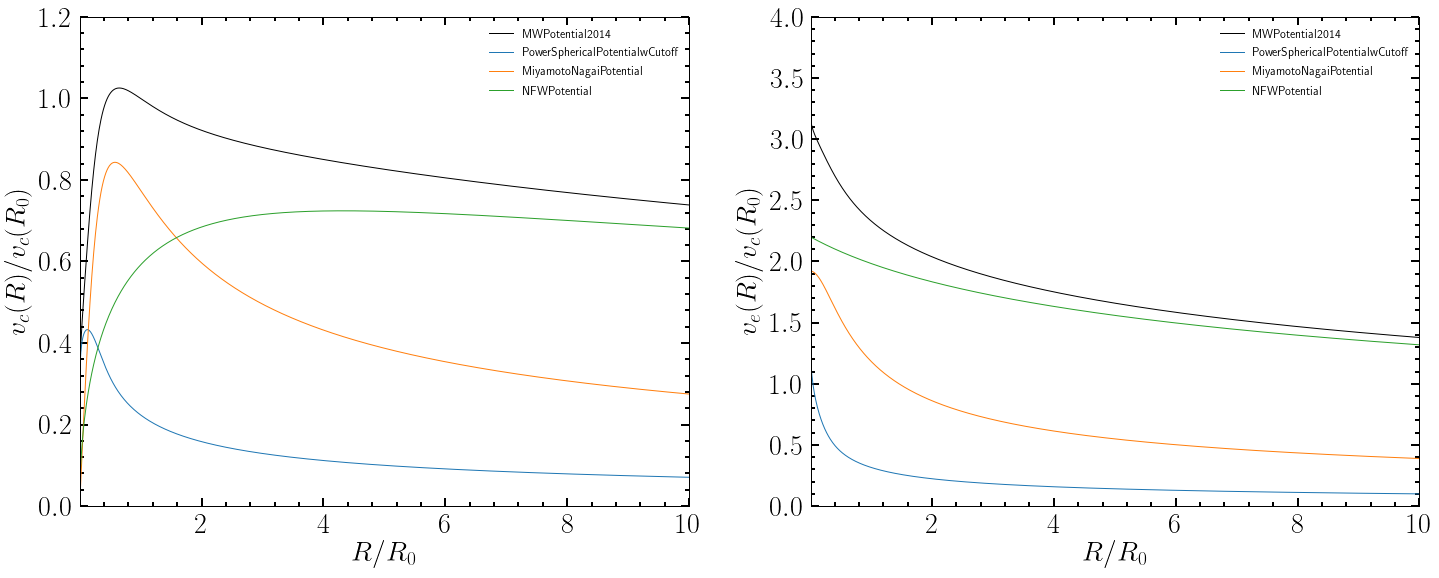

In [15]:
from galpy.potential import plotRotcurve
from galpy.potential import plotEscapecurve

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(24, 9))

# Plot the combined potential
pyplot.sca(ax1)
plotRotcurve(MWPotential2014, Rrange=[0.01, 10.0], grid=1001, yrange=[0.0, 1.2],
             label="MWPotential2014", ls="-", c="k", gcf=True)
# Plot the individual components
bulge.plotRotcurve(Rrange=[0.01, 10.0], grid=1001, overplot=True, label="PowerSphericalPotentialwCutoff")
disk.plotRotcurve(Rrange=[0.01, 10.0], grid=1001, overplot=True, label="MiyamotoNagaiPotential")
dm.plotRotcurve(Rrange=[0.01, 10.0], grid=1001, overplot=True, label="NFWPotential")
ax1.legend(frameon=False, fontsize=12)


# Plot the combined potential
pyplot.sca(ax2)
plotEscapecurve(MWPotential2014, Rrange=[0.01, 10.0], grid=1001, yrange=[0.0, 4.0],
                label="MWPotential2014", ls="-", c="k", gcf=True)
# Plot the individual components
bulge.plotEscapecurve(Rrange=[0.01, 10.0], grid=1001, overplot=True, label="PowerSphericalPotentialwCutoff")
disk.plotEscapecurve(Rrange=[0.01, 10.0], grid=1001, overplot=True, label="MiyamotoNagaiPotential")
dm.plotEscapecurve(Rrange=[0.01, 10.0], grid=1001, overplot=True, label="NFWPotential")
ax2.legend(frameon=False, fontsize=12)

pyplot.show()

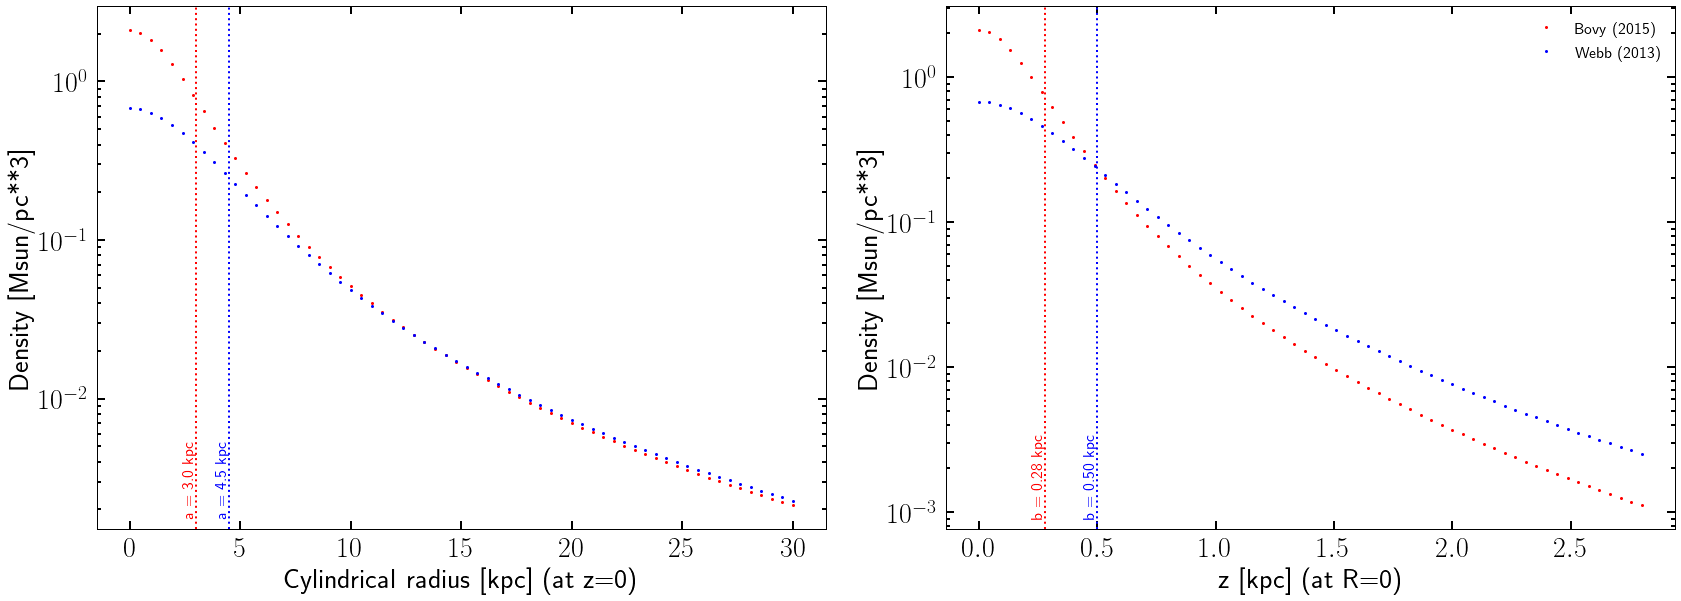

/usr/local/lib/python3.8/site-packages/galpy/util/bovy_plot.py:644: UserWarning: The following kwargs were not used by contour: 'aspect'
  cont= pyplot.contour(cntrThis,levels,colors=cntrcolors,



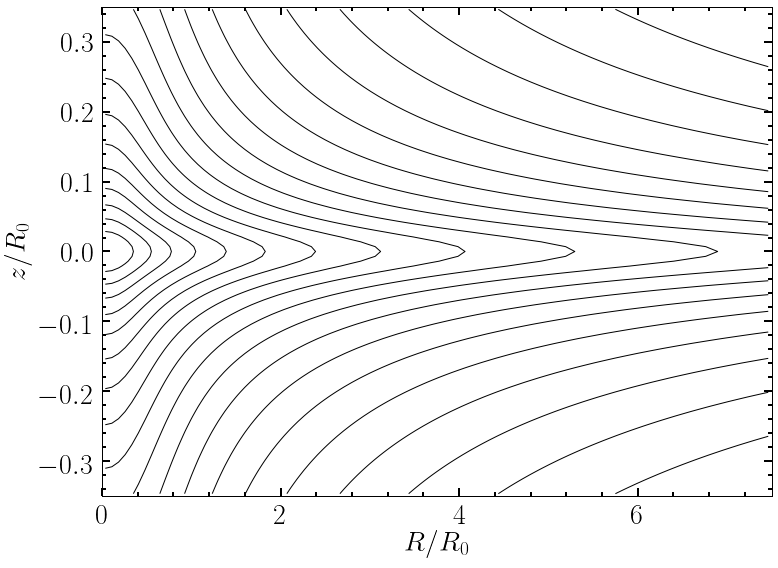

In [16]:
fig, (ax, ax2) = pyplot.subplots(1, 2, figsize=(24, 9))

for i, r in enumerate(numpy.linspace(0, 30, 64)):
    ax.plot(r, disk.dens(r*u.kpc, z=0*u.kpc)*to_msunpc3, "ro", label="Bovy (2015)" if i == 0 else "")
    ax.plot(r, disk_webb_2013.dens(r*u.kpc, z=0*u.kpc)*to_msunpc3, "bo", label="Webb (2013)" if i == 0 else "")

ax.set_xlabel("Cylindrical radius [kpc] (at z=0)")
ax.set_ylabel("Density [Msun/pc**3]")
# ax.set_xscale("log")
ax.set_yscale("log")

# a=3, so where is it?
ax.axvline(3.0, c="r", ls=":", lw=2)
ax.axvline(4.5, c="b", ls=":", lw=2)
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.text(3.0, 0.02, "a = 3.0 kpc", c="red", rotation=90, ha="right", va="bottom", fontsize=16, transform=trans)
ax.text(4.5, 0.02, "a = 4.5 kpc", c="blue", rotation=90, ha="right", va="bottom", fontsize=16, transform=trans)

for i, z in enumerate(numpy.linspace(0, 2.8, 64)):
    ax2.plot(z, disk.dens(0*u.kpc, z=z*u.kpc)*to_msunpc3, "ro", label="Bovy (2015)" if i == 0 else "")
    ax2.plot(z, disk_webb_2013.dens(0*u.kpc, z=z*u.kpc)*to_msunpc3, "bo", label="Webb (2013)" if i == 0 else "")

ax2.set_xlabel("z [kpc] (at R=0)")
ax2.set_ylabel("Density [Msun/pc**3]")
# ax2.set_xscale("log")
ax2.set_yscale("log")

# b=0.28, so where is it?
ax2.axvline(0.28, c="r", ls=":", lw=2)
ax2.axvline(0.5, c="b", ls=":", lw=2)
trans = matplotlib.transforms.blended_transform_factory(ax2.transData, ax2.transAxes)
ax2.text(0.28, 0.02, "b = 0.28 kpc", c="red", rotation=90, ha="right", va="bottom", fontsize=16, transform=trans)
ax2.text(0.50, 0.02, "b = 0.50 kpc", c="blue", rotation=90, ha="right", va="bottom", fontsize=16, transform=trans)
ax2.legend(loc="upper right", fontsize=16, frameon=False)

pyplot.tight_layout()
pyplot.show(fig)

disk.plotDensity(rmin=0*u.kpc, rmax=60*u.kpc, zmin=-2.8*u.kpc, zmax=2.8*u.kpc, nrs=101, nzs=101, ncontours=21, log=True, justcontours=True)
pyplot.show()

# Test Orbit integrations of NGC 104 /w Hilker+ 2019 initial conditions for Galpy's built-in integrator as well as for an Nbody (N=1) star cluster using to_amuse as external potential and integrating with AMUSE/Gadget2

In [17]:
from amuse.units import units
from amuse.support.console import set_printing_strategy
set_printing_strategy("custom", preferred_units=[
    units.MSun, units.parsec, units.Myr, units.kms],
    precision=2, prefix="", separator=" ", suffix="")

In [18]:
# This repo: src folder /w Python scripts
sys.path.insert(0, "../src")
from galpy_amuse import compare_galpy_and_amuse
from galpy_amuse import convert_galpy_to_amuse_times
from galpy_amuse import plot_stars

# Data needed for the initial conditions
gc_name = "NGC 104"
igc, = numpy.where(h19_orbits["Cluster"] == gc_name)[0]
imatch, = numpy.where(h19_combined["Cluster"] == gc_name)[0]

# Simulation runtime
ts = numpy.linspace(0.0, 1, 256+1) * u.Gyr
tstart, tend, Nsteps, dt = convert_galpy_to_amuse_times(ts)

# Here we define the function that operates on the particle data during the simulation
com = numpy.zeros((Nsteps,3))
times = numpy.zeros(Nsteps)
def calculate_com_and_plot_stars(stars, time, i, fname="test_"):
    print_progressbar(i, Nsteps)
    c = stars.center_of_mass().value_in(units.parsec)
    com[i][:] = c
    times[i] = time.value_in(units.Myr)
    plot_stars(stars, time, i, fname=fname)

    return stars

# Do the orbit integrations with Galpy (analytical, fast)
# as well as with AMUSE/Gadget2 (Nbody, expensive)
o = compare_galpy_and_amuse(
    logger, 
    h19_orbits[igc],
    h19_combined[imatch],
    N=1, ts=ts, do_something=lambda stars, time, i: calculate_com_and_plot_stars(stars, time, i, fname="ngc104_Nstars=1_"),
    number_of_workers=1,
)

Integrating Galpy.Orbit from T=0.0 Gyr to T=1.0 Gyr in N=257 steps
Integrating AMUSE orbit from T=0.0 Gyr to T=1.0 Gyr in N=257 steps, dt=3.8910505836575875 Myr
-----------------------------------------------------------------------------------------------------
gc_name        RA        Dec       R_Sun     v_r       pmRA      pmDec     |   R_peri    R_apo     
               deg       deg       kpc       km/s      mas/yr    mas/yr    |                       
-----------------------------------------------------------------------------------------------------
NGC 104        6.02      -72.08    4.43      -17.21    5.25      -2.53     |   5.46      7.44      
Runtime Galpy Orbit integration: 0.03 seconds
  Orbit        6.02      -72.08    4.43      -17.21    5.25      -2.53     |   5.36      7.39      
Progress: [##########################################] 100.0% .. done
Runtime AMUSE Orbit integration: 71.01 seconds
------------------------------------------------------------------------

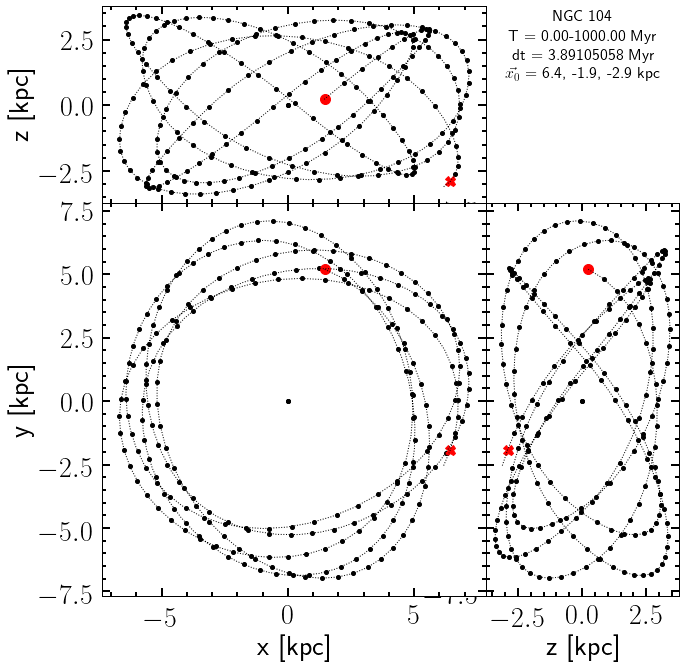

In [19]:
from galpy_amuse import plot_galpy_and_amuse_integrations
plot_galpy_and_amuse_integrations(o, com, ts, gc_name)

# Now we want to sample NGC 104 with a realistic density structure

In [21]:
from amuse.ic.plummer import new_plummer_sphere
from amuse.units import nbody_system, units

converter = nbody_system.nbody_to_si(1e5|units.MSun, 3|units.parsec)
plummer = new_plummer_sphere(10, converter)

from tlrh_datamodel import get_radial_profiles
radii, N_in_shell, M_below_r, rho_of_r, volume = get_radial_profiles(plummer)

In [22]:
plummer.potential().value_in(units.J/units.kg)

array([ -1.77178978e+08,  -2.12752500e+08,  -1.52303944e+08,
        -2.10948636e+08,  -1.15920206e+08,  -1.68976611e+08,
        -1.36169070e+08,  -1.22357883e+08,  -1.82117694e+08,
        -6.02784556e+07])

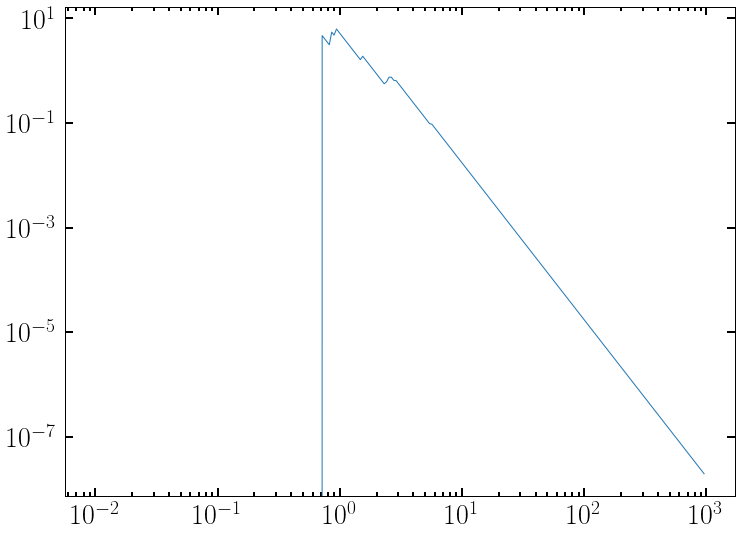

In [23]:
pyplot.loglog(radii.value_in(units.parsec), N_in_shell/volume)

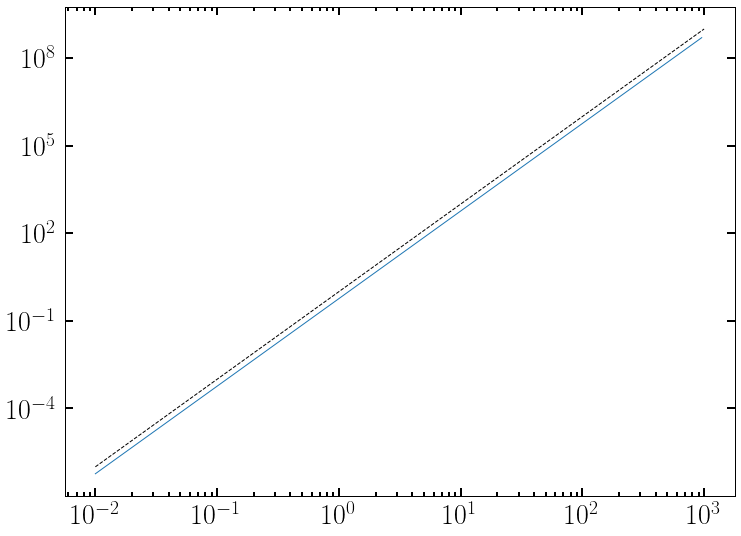

In [24]:
x = numpy.logspace(-2, 3, 128)
pyplot.loglog(x, x**3, c="k", ls="--")  # because Euclidean space
pyplot.loglog(radii.value_in(units.parsec), volume)

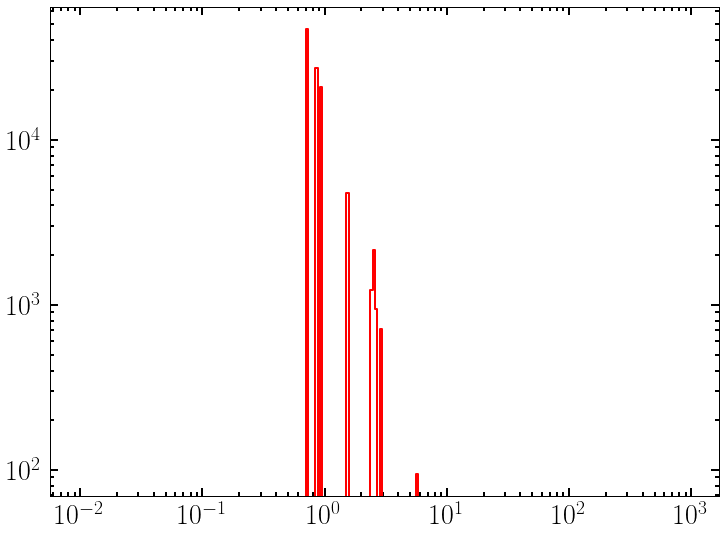

In [25]:
pyplot.loglog(radii.value_in(units.parsec),
    rho_of_r.value_in(units.MSun/units.parsec**3),
    c="r", lw=2, drawstyle="steps-mid", label="sampled")


In [26]:
pyplot.plot(m.r, m.phihat)

NameError: name 'm' is not defined

In [ ]:
pyplot.loglog(m.r, m.phi)
pyplot.loglog(m.r, m.phihat)

In [ ]:
pyplot.loglog(radii.value_in(units.parsec),
    vel_of_r,
    c="r", lw=2, drawstyle="steps-mid", label="sampled")

In [ ]:
pyplot.loglog(m.r, m.v2, label="v2")
pyplot.loglog(m.r, m.v2r, label="v2r")
pyplot.loglog(m.r, m.v2t, label="v2t")
pyplot.loglog(m.r, m.v2p, label="v2p")
pyplot.loglog(m.r, m.v2R, label="v2R")
pyplot.loglog(m.r, m.v2T, label="v2T")
pyplot.legend()

In [ ]:
# Integrate the distribution function over velocities to get positions
import scipy
for N in [256, 512, 1024, 2048]:
    for ls, vmin in zip([":", "--", "-.", "-"], [10, 8, 6, 4]):
        v = numpy.logspace(-vmin, vmin, N)
        n = [scipy.integrate.simps(m.df(ri, v), x=v) for ri in m.r]
        pyplot.loglog(n, m.r, ls=ls, label="N={0}, vmin={1}".format(N, vmin))
pyplot.xlabel("Radius [parsec]")
pyplot.legend()
print(n[0])

In [27]:
Ekin = a.kinetic_energy()
Epot = a.potential_energy()

print("Ekin: {:.2e} J".format(Ekin.value_in(units.J)))
print("Epot: {:.2e} J".format(Epot.value_in(units.J)))

print("Ekin: {:.2e} erg".format(Ekin.value_in(units.erg)))
print("Epot: {:.2e} erg".format(Epot.value_in(units.erg)))

NameError: name 'a' is not defined

In [28]:
psi0 = numpy.mean(phi_of_r[numpy.isfinite(phi_of_r)][0:5]) | units.J/units.kg
print("psi0: {0:.2e} J/kg".format(psi0.value_in(units.J/units.kg)))
print("psi0: {0:.2e} erg/g".format(psi0.value_in(units.erg/units.g)))
print("psi0: {0:.2e} J/MSun".format(psi0.value_in(units.J/units.MSun)))
print("psi0: {0:.2e} erg/MSun".format(psi0.value_in(units.erg/units.MSun)))

NameError: name 'phi_of_r' is not defined

In [29]:
pyplot.semilogx(radii.value_in(units.parsec), phi_of_r,
    c="r", lw=2, drawstyle="steps-mid", label="sampled")

NameError: name 'phi_of_r' is not defined

In [31]:
from galpy_amuse import limepy_to_amuse
from tlrh_datamodel import get_radial_profiles
from tlrh_datamodel import plot_radial_profiles

Nstars, rmin, rmax = 10000, 1e-2, 1e4
m, p, a = limepy_to_amuse(7, M=1e5, rt=30, g=1, Nstars=Nstars, seed=1337)

radii, N_in_shell, M_below_r, rho_of_r, volume, = \
    get_radial_profiles(a, Nbins=64, rmin=rmin, rmax=rmax)

../src/tlrh_datamodel.py:113: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax3.set_ylim(



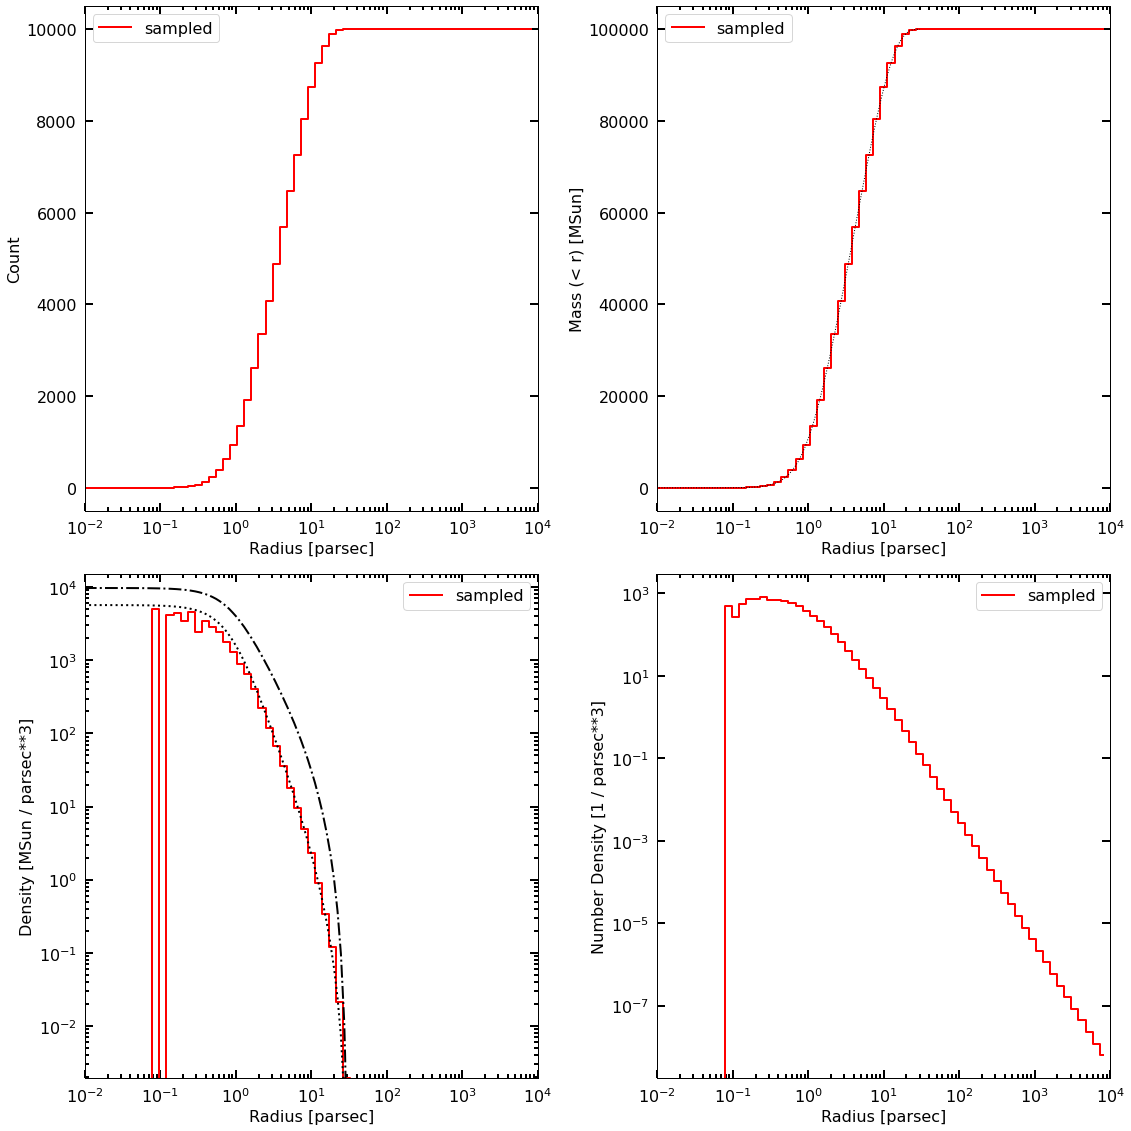

In [34]:
fig, (ax1, ax2, ax3, ax4) = plot_radial_profiles(
    radii, N_in_shell, M_below_r, rho_of_r, volume,
    rmin=rmin, rmax=rmax, has_tex=False
)

ax2.plot(m.r, m.mc, c="k", ls=":", label="Model")

irhomax = numpy.where(N_in_shell == Nstars)[0][0]
irhomin = numpy.where(rho_of_r.value_in(units.MSun/units.parsec**3) > 1e-12)[0][0]
ax3.plot(m.r, m.rho, c="k", ls=":", lw=2, label="Model")
ax3.plot(m.R, m.Sigma, c="k", ls="-.", lw=2, label="Sigma(R)")
ax3.set_ylim(rho_of_r[irhomax].value_in(units.MSun/units.parsec**3), 3*rho_of_r[irhomin].value_in(units.MSun/units.parsec**3))

pyplot.tight_layout()
pyplot.show(fig)

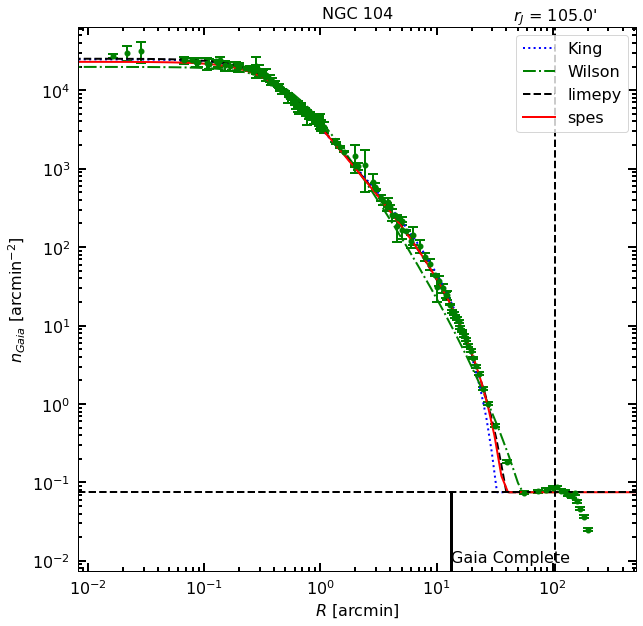

In [36]:
matplotlib.rcParams.update({"text.usetex": False})

gc_name = "NGC 104"
ingc104, = numpy.where(deB19_fits["id"] == gc_name)[0]
distance_kpc = h96_gc[gc_name].dist_from_sun
imatch, = numpy.where(b18["Name"] == gc_name)[0]
rJ_pc = b18[imatch]["r_J"]
rJ = parsec2arcmin(rJ_pc, distance_kpc)
fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))
fig = plot_deBoer_2019(logger, deB19_fits[ingc104], deB19_stitched[gc_name], distance_kpc, rJ_pc, rJ, fig=fig, has_tex=False)
pyplot.show(fig)

matplotlib.rcParams.update({"text.usetex": True})

# Test 2: what does the CoM of the orbit look like when integrated for 1 Gyr /w N>1 Nbody representation of the star cluster?

In [ ]:
o = compare_galpy_and_amuse(
    logger, 
    h19_orbits[igc],
    h19_combined[imatch],
    N=1000, ts=ts, do_something=lambda stars, time, i: calculate_com_and_plot_stars(stars, time, i, fname="ngc104_Nstars=1000_"),
    number_of_workers=1,
)
plot_galpy_and_amuse_integrations(o, com, ts, gc_name)

In [ ]:
from tlrh_plummer import *
from tlrh_king import *
from tlrh_datamodel import get_radial_profiles
from tlrh_datamodel import plot_radial_profiles
from tlrh_datamodel import scatter_particles_xyz
from tlrh_datamodel import print_particleset_info

# Integrate Orbit of the GC in Hilker+ 2019 /w Galpy's Orbit.integrate and /w to_amuse, given the MWPotential2014

In [ ]:
# os.system('ffmpeg -y -r 5 -i "../out/test_%3d.png" -profile:v high444 -level 4.1 -c:v libx264 -preset slow -crf 25 -s "2000:2000" -an "test.mp4"')